# Projeto 3 - Ciência dos Dados - Regressão & Criptomoedas

**Alunos** :  Lucas Muchaluat, Luiz Vitor Germanos e Matheus Ferreira

**Turma** :  Engenharia 2B

### Introdução

 Nesse documento você encontrará uma análise sobre a relação entre o bitcoin e o ouro em uma tentativa de prever o preço do ouro (Spot) baseado no preço do bitcoin. Partimos da premissa que ambos os ativos servem como _____ e portanto teriam algum tipo de correlação. Nossa análise consiste em fazer regressões e a partir das regressões validar as relações entre os dois ativos. 

**Pergunta norteadora:**

### Importando as bibliotecas

In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy.stats import norm, probplot
import statsmodels.api as sm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use('fivethirtyeight')
# # plt.style.use('ggplot')

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Obtendo as bases de dados 

In [2]:
#lendo informação obtida no site coinmarketcap.com
cmc_2017 = pd.read_csv("coinmarketcap_06122017.csv")
#imprimindo as primeiras linhas do dataset
cmc_2017.head(5)

,Unnamed: 0,24h_volume_usd,available_supply,id,last_updated,market_cap_usd,max_supply,name,percent_change_1h,percent_change_24h,percent_change_7d,price_btc,price_usd,rank,symbol,total_supply
0,0,9.007640e+09,1.672352e+07,bitcoin,1512549554,2.130493e+11,2.100000e+07,Bitcoin,0.12,7.33,17.45,1.000000,12739.500000,1,BTC,1.672352e+07
1,1,1.551330e+09,9.616537e+07,ethereum,1512549553,4.352945e+10,NaN,Ethereum,-0.18,-3.93,-7.33,0.036177,452.652000,2,ETH,9.616537e+07
2,2,1.111350e+09,1.684044e+07,bitcoin-cash,1512549578,2.529585e+10,2.100000e+07,Bitcoin Cash,1.65,-5.51,-4.75,0.120050,1502.090000,3,BCH,1.684044e+07
3,3,2.936090e+09,2.779530e+09,iota,1512549571,1.475225e+10,2.779530e+09,IOTA,-2.38,83.35,255.82,0.000424,5.307460,4,MIOTA,2.779530e+09
4,4,2.315050e+08,3.873915e+10,ripple,1512549541,9.365343e+09,1.000000e+11,Ripple,0.56,-3.70,-14.79,0.000019,0.241754,5,XRP,9.999309e+10


In [3]:
#realizando os mesmos passos feitos acima para 2018
cmc_2018 = pd.read_csv("coinmarketcap_06012018.csv")
cmc_2018.head(5)

,Unnamed: 0,24h_volume_usd,available_supply,id,last_updated,market_cap_usd,max_supply,name,percent_change_1h,percent_change_24h,percent_change_7d,price_btc,price_usd,rank,symbol,total_supply
0,0,22081300000,16785225,bitcoin,1515230661,284909052105,2.100000e+07,Bitcoin,-0.42,5.76,26.04,1.000000,16973.800000,1,BTC,16785225
1,1,5221370000,38739144847,ripple,1515230641,119207709132,1.000000e+11,Ripple,-0.26,-9.23,24.15,0.000186,3.077190,2,XRP,99993093880
2,2,5705690000,96803840,ethereum,1515230649,100115499075,NaN,Ethereum,0.29,-1.04,45.01,0.062517,1034.210000,3,ETH,96803840
3,3,1569900000,16896225,bitcoin-cash,1515230652,44424061657,2.100000e+07,Bitcoin Cash,0.03,7.99,2.81,0.158934,2629.230000,4,BCH,16896225
4,4,428305000,25927070538,cardano,1515230654,25916647856,4.500000e+10,Cardano,0.39,-5.87,64.99,0.000060,0.999598,5,ADA,31112483745


In [4]:
#listando as colunas do dataset
list(cmc_2017)

['Unnamed: 0',
 '24h_volume_usd',
 'available_supply',
 'id',
 'last_updated',
 'market_cap_usd',
 'max_supply',
 'name',
 'percent_change_1h',
 'percent_change_24h',
 'percent_change_7d',
 'price_btc',
 'price_usd',
 'rank',
 'symbol',
 'total_supply']

### Recortando e preparando os datasets

In [5]:
# Selecionando as colunas 'name' e 'market_cap_usd'
market_cap_2017 = cmc_2017[['name', 'market_cap_usd']]
market_cap_2018 = cmc_2018[['name', 'market_cap_usd']]

# Contando o número de valores de cada uma delas
market_cap_2017.count()

name              1326
market_cap_usd    1031
dtype: int64

 Como existem mais "id" que "market caps" podemos concluir que existem moedas sem um share no mercado

In [6]:
# Filtrando as linhas sem um market capitalization
# market_cap = market_cap.query('market_cap_usd > 0')
market_cap_2017 = market_cap_2017[market_cap_2017["market_cap_usd"]>0]
market_cap_2018 = market_cap_2018[market_cap_2018["market_cap_usd"]>0]

# Contando o número de valores novamente
market_cap_2017.count()

name              1031
market_cap_usd    1031
dtype: int64

### Analisando o tamanho de cada moeda no mercado

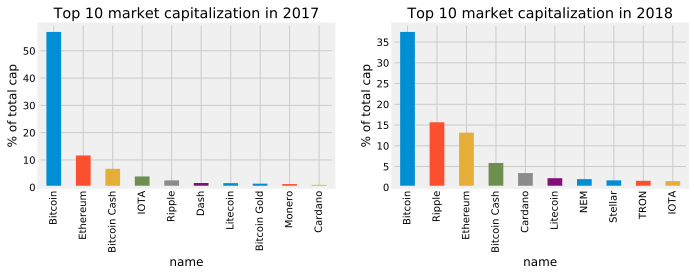

In [7]:
# Selecionando as 10 primeiras linhas e setando o index via nome da moeda
market_cap10_2017 = market_cap_2017.head(10).set_index('name')
market_cap10_2018 = market_cap_2018.head(10).set_index('name')

# Calculando porcentagem do market cap da moeda em relação ao total
market_cap10_2017 = market_cap10_2017.assign(market_cap_perc_2017 = lambda x: (x["market_cap_usd"] / market_cap_2017["market_cap_usd"].sum()) * 100)
market_cap10_2018 = market_cap10_2018.assign(market_cap_perc_2018 = lambda x: (x["market_cap_usd"] / market_cap_2018["market_cap_usd"].sum()) * 100)

# Plotando o gráfico de barras para analisar o tamanho que cada moeda tem no mercado de criptos
plt.figure(figsize=(16,3))
plt.subplot(131)
plot = market_cap10_2017.market_cap_perc_2017.plot.bar(title='Top 10 market capitalization in 2017')
plot.set_ylabel('% of total cap')

plt.subplot(132)
plot = market_cap10_2018.market_cap_perc_2018.plot.bar(title='Top 10 market capitalization in 2018')
plot.set_ylabel('% of total cap');

Se formos analisar as top 3 criptomoedas mais dominantes do mercado em ambos os anos, conseguimos perceber uma que domina recorrentemente o mercado: BITCOIN.

### Visualizando inicialmente a moeda em questão

##### Market Info do Bitcoin

In [8]:
# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# this will remove those asterisks
bitcoin_market_info.columns = bitcoin_market_info.columns.str.replace("*", "")
# look at the first few rows
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-11-21,4465.54,4675.73,4343.98,4602.17,6120120000,80020171047
1,2018-11-20,4863.93,4951.61,4272.11,4451.87,8428290000,77401044320
2,2018-11-19,5620.78,5620.78,4842.91,4871.49,7039560000,84688539692
3,2018-11-18,5559.74,5653.61,5559.74,5623.54,4159680000,97753714643
4,2018-11-17,5578.58,5578.58,5519.56,5554.33,4303150000,96542098114


In [9]:
#adicionando uma coluna da variação no preço do bitcoin a cada dia
bitcoin_market_info['Delta Bitcoin'] = (bitcoin_market_info['Close'] - bitcoin_market_info['Open'])/bitcoin_market_info['Open']
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap,Delta Bitcoin
0,2018-11-21,4465.54,4675.73,4343.98,4602.17,6120120000,80020171047,136.63
1,2018-11-20,4863.93,4951.61,4272.11,4451.87,8428290000,77401044320,-412.06
2,2018-11-19,5620.78,5620.78,4842.91,4871.49,7039560000,84688539692,-749.29
3,2018-11-18,5559.74,5653.61,5559.74,5623.54,4159680000,97753714643,63.80
4,2018-11-17,5578.58,5578.58,5519.56,5554.33,4303150000,96542098114,-24.25


In [10]:
#analisando o closing price do bitcoin
bitcoin_market_info['Close'].describe()

count     2034.000000
mean      2280.187173
std       3443.225874
min         68.430000
25%        320.270000
50%        596.425000
75%       2576.057500
max      19497.400000
Name: Close, dtype: float64

##### Plotando o closing price ao longo do tempo 

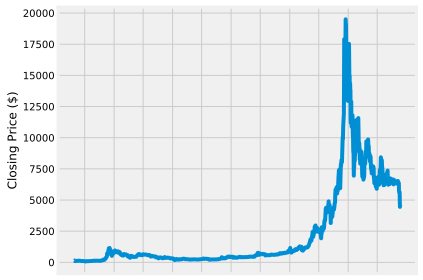

In [11]:
fig, ax1 = plt.subplots(1,1, gridspec_kw = {'height_ratios':[3]})
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax1.plot(bitcoin_market_info['Date'].astype(datetime.datetime),bitcoin_market_info['Close'])
fig.tight_layout()
plt.show()

### Comparando a moeda com o Ouro (XAU)

##### Obtendo os dados a respeito do ouro

In [12]:
Ouro = pd.read_excel('XAU_USD Historical Data (1) 2.xlsx')
Ouro = Ouro.assign(Date=pd.to_datetime(Ouro['Date']))
Ouro["Delta Ouro"] = Ouro["Price"] - Ouro["Open"]
Ouro.set_index('Date',inplace = True)
Ouro.head()

,Price,Open,High,Low,Change %,Delta Ouro
Date,,,,,,
2018-11-21,1225.83,1221.74,1230.12,1219.87,0.0035,4.09
2018-11-20,1221.55,1224.37,1229.17,1219.67,-0.0020,-2.82
2018-11-19,1224.05,1221.76,1225.26,1217.52,0.0012,2.29
2018-11-18,1222.62,1222.49,1222.84,1221.69,0.0009,0.13
2018-11-16,1221.47,1213.02,1225.37,1212.48,0.0070,8.45


##### Cruzando os datasets (Ouro e Bitcoin)

In [13]:
#Cruza as duas tabelas (bitcoin e ouro) via data
bitcoin_market_info.set_index('Date', inplace=True)
# Ouro.set_index('Date', inplace=True)
df = bitcoin_market_info.join(Ouro, how='inner', lsuffix='_btc', rsuffix='_ouro')
df.head(5)

,Open_btc,High_btc,Low_btc,Close,Volume,Market Cap,Delta Bitcoin,Price,Open_ouro,High_ouro,Low_ouro,Change %,Delta Ouro
Date,,,,,,,,,,,,,
2018-11-21,4465.54,4675.73,4343.98,4602.17,6120120000,80020171047,136.63,1225.83,1221.74,1230.12,1219.87,0.0035,4.09
2018-11-20,4863.93,4951.61,4272.11,4451.87,8428290000,77401044320,-412.06,1221.55,1224.37,1229.17,1219.67,-0.0020,-2.82
2018-11-19,5620.78,5620.78,4842.91,4871.49,7039560000,84688539692,-749.29,1224.05,1221.76,1225.26,1217.52,0.0012,2.29
2018-11-18,5559.74,5653.61,5559.74,5623.54,4159680000,97753714643,63.80,1222.62,1222.49,1222.84,1221.69,0.0009,0.13
2018-11-16,5645.32,5657.02,5498.94,5575.55,5279320000,96900828780,-69.77,1221.47,1213.02,1225.37,1212.48,0.0070,8.45


### Montando a Regressão

In [14]:
# Função utilitária para fazer a regressão com constante adicionada
def regress_com_const(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

In [15]:
# Função utilitária para fazer a regressão sem constante adicionada
def regress_sem_const(X,Y):
    model = sm.OLS(Y,X)
    results = model.fit()
    return results

##### Regressão Linear Simples (apenas bitcoin)

Aqui vale ressaltar que faz mais sentido analisar a variação diária do preço do bitcoin e do ouro, visto que os resultados saem mais significativos.

In [16]:
#Seleciona os deltas em comparação, além de remover os NaNs
simples = df[['Delta Bitcoin','Delta Ouro']].dropna()

x = simples['Delta Bitcoin']
y = simples['Delta Ouro']

**Regressão feita com a constante adicionada**

In [17]:
results1 = regress_com_const(x,y)
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Delta Ouro   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7209
Date:                Thu, 22 Nov 2018   Prob (F-statistic):              0.396
Time:                        21:33:17   Log-Likelihood:                -5648.6
No. Observations:                1477   AIC:                         1.130e+04
Df Residuals:                    1475   BIC:                         1.131e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0771      0.289      0.267      0.789      -0.489       0.643
Delta Bitcoin    -0.0010      0.001     -0.849      0.396      -0.003       0.001
==============================================================================
Omnibus:                      135.312   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              883.788
Skew:                          -0.028   Prob(JB):                    1.22e-192
Kurtosis:                       6.789   Cond. No.                         247.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

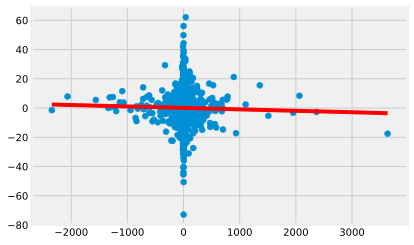

In [20]:
#plotando o gráfico da regressão
x_v = np.linspace(x.min(), x.max(), 500)
x_vc = sm.add_constant(x_v)
y_vc = results1.predict(x_vc)
plt.plot(x_v, y_vc, color="r")
plt.scatter(x,y);

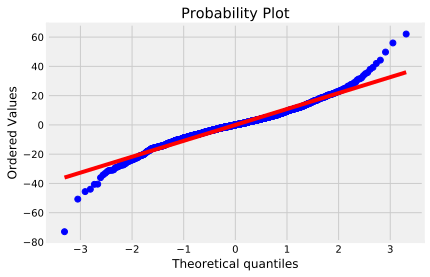

In [21]:
#verificando normalidade dos resíduos
probplot(results1.resid, dist="norm", plot=plt);

**Regressão feita sem a constante adicionada**

In [19]:
results2 = regress_sem_const(x,y)
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Delta Ouro   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7191
Date:                Thu, 22 Nov 2018   Prob (F-statistic):              0.397
Time:                        21:38:45   Log-Likelihood:                -5648.6
No. Observations:                1477   AIC:                         1.130e+04
Df Residuals:                    1476   BIC:                         1.130e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Delta Bitcoin    -0.0010      0.001     -0.848      0.397      -0.003       0.001
==============================================================================
Omnibus:                      135.312   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              883.787
Skew:                          -0.028   Prob(JB):                    1.22e-192
Kurtosis:                       6.789   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#COMO FAZER GRAFICO SEM A CONSTANTE ADICIONADA?

##### Regressão Linear Múltipla (analisando influência de outras moedas além do bitcoin)

ETHEREUM

In [ ]:
# get market info for ethereum from the start of 2016 to the current day
ethereum_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
ethereum_market_info = ethereum_market_info.assign(Date=pd.to_datetime(ethereum_market_info['Date']))
# when Volume is equal to '-' convert it to 0
# ethereum_market_info.loc[ethereum_market_info['Volume']=="-",'Volume']=0
# convert to int
ethereum_market_info['Volume'] = ethereum_market_info['Volume'].astype('int64')
# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# this will remove those asterisks
ethereum_market_info.columns = ethereum_market_info.columns.str.replace("*", "")
ethereum_market_info['Delta Ethereum'] = (ethereum_market_info['Close'] - ethereum_market_info['Open'])/ethereum_market_info['Open']
# look at the first few rows
ethereum_market_info.head()

RIPPLE

In [ ]:
# get market info for bitcoin from the start of 2016 to the current day
ripple_market_info = pd.read_html("https://coinmarketcap.com/currencies/ripple/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
ripple_market_info = ripple_market_info.assign(Date=pd.to_datetime(ripple_market_info['Date']))
# when Volume is equal to '-' convert it to 0
ripple_market_info.loc[ripple_market_info['Volume']=="-",'Volume']=0
# convert to int
ripple_market_info['Volume'] = ripple_market_info['Volume'].astype('int64')
# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# this will remove those asterisks
ripple_market_info.columns = ripple_market_info.columns.str.replace("*", "")
ripple_market_info['Delta Ripple'] = (ripple_market_info['Close'] - ripple_market_info['Open'])/ripple_market_info['Open']
# look at the first few rows
ripple_market_info.head()

##### Juntando os deltas das outras moedas em um unico dataset

In [ ]:
#Cruza as duas tabelas via data
bitcoin_market_info.set_index('Date', inplace=True)
ethereum_market_info.set_index('Date',inplace = True)
ripple_market_info.set_index('Date',inplace = True)
df2 = bitcoin_market_info.join(Ouro, how='inner', lsuffix='_btc', rsuffix='_ouro')
df2 = df2.join(ethereum_market_info)
df2 = df2.join(ripple_market_info, how='inner', lsuffix='_eth', rsuffix='_rpl')
df2.head(5)

In [ ]:
multipla = df2[['Delta Ouro', 'Delta Bitcoin', 'Delta Ethereum', 'Delta Ripple']].dropna()

In [ ]:
Y = multipla['Delta Ouro']
X = multipla[['Delta Bitcoin', 'Delta Ethereum', 'Delta Ripple']]

In [ ]:
results3 = regress(X,Y)
results3.summary()

##### Montando um gráfico para analisar melhor a previsão do delta do ouro com base no delta do bitcoin e do ethereum (2 mais dominantes do mercado)

In [ ]:
X3 = multipla[['Delta Bitcoin',
       'Delta Ethereum']]
results4 = regress(X3, Y)
results4.summary()

In [ ]:
c = results4.params["const"]
w = results4.params["Delta Bitcoin"]
u = results4.params["Delta Ethereum"]

In [ ]:
def f(delta_btc, delta_eth):
    return c+w*delta_btc + u*delta_eth

In [ ]:
npoints = 100
delta_btc = np.linspace(X3["Delta Bitcoin"].min(), X3["Delta Bitcoin"].max(), npoints)
delta_eth = np.linspace(X3["Delta Ethereum"].min(), X3["Delta Ethereum"].max(), npoints)

In [ ]:
delta_btc_xx, delta_eth_yy = np.meshgrid(delta_btc, delta_eth)

In [ ]:
z = f(delta_btc_xx, delta_eth_yy)

In [ ]:
plt3d = plt.figure().gca(projection="3d")
plt3d.plot_surface(close_xx, market_cap_yy, z)
plt3d.scatter(X3["Delta Bitcoin"],X3["Delta Ethereum"], Y , color="r")